In [101]:
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
from tqdm import tqdm
import matplotlib.pyplot as plt

#### Autoencoder with PyTorch-Lightning

In [97]:
class Autoencoder(pl.LightningModule):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        # contracting path
        self.down_nn_1 = self.nn_layer(in_features=784, out_features=512)
        self.down_nn_2 = self.nn_layer(in_features=512, out_features=256)
        self.down_nn_3 = self.nn_layer(in_features=256, out_features=128)
        self.down_nn_4 = self.nn_layer(in_features=128, out_features=64)
        self.down_nn_5 = self.nn_layer(in_features=64, out_features=32)
        # expansive path
        self.up_nn_1 = self.nn_layer(in_features=32, out_features=64)
        self.up_nn_2 = self.nn_layer(in_features=64, out_features=128)
        self.up_nn_3 = self.nn_layer(in_features=128, out_features=256)
        self.up_nn_4 = self.nn_layer(in_features=256, out_features=512)
        self.output = self.nn_layer(in_features=512, out_features=784)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        # x.size() -> [batch_size, width, height] convert this to [batch_size, width*height]
        x1 = self.relu(self.down_nn_1(x))
        x2 = self.relu(self.down_nn_2(x1))
        x3 = self.relu(self.down_nn_3(x2))
        x4 = self.relu(self.down_nn_4(x3))
        x5 = self.relu(self.down_nn_5(x4))
        x_4 = self.relu(self.up_nn_1(x5))
        x_3 = self.relu(self.up_nn_2(x_4))
        x_2 = self.relu(self.up_nn_3(x_3))
        x_1 = self.relu(self.up_nn_4(x_2))
        out = self.relu(self.output(x_1))
        return out
        
    def nn_layer(self, in_features, out_features):
        layer = nn.Linear(in_features=in_features, out_features=out_features)
        return layer
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def prepare_data(self, train=True):
        data = torchvision.datasets.MNIST(
            root="./data/",
            train=train,
            transform=torchvision.transforms.ToTensor(),
            download=True
        )
        return data
    
    def train_dataloader(self):
        data = self.prepare_data(train=True)
        loader = torch.utils.data.DataLoader(dataset=data, batch_size=64, shuffle=True)
        return loader
    
    def training_step(self, batch, batch_idx):
        x, y = batch
#         print(x.size())
        x = x.view(-1, x.size(2)*x.size(3))
#         print(x.size())
        x_new = self(x)
#         x = x.long()
#         print(x_new.dtype)
        loss = torch.nn.functional.mse_loss(x_new, x)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

In [98]:
model = Autoencoder()

In [99]:
trainer = pl.Trainer(gpus=[0], max_epochs=50, show_progress_bar=True)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [100]:
trainer.fit(model)


   | Name      | Type   | Params
---------------------------------
0  | down_nn_1 | Linear | 401 K 
1  | down_nn_2 | Linear | 131 K 
2  | down_nn_3 | Linear | 32 K  
3  | down_nn_4 | Linear | 8 K   
4  | down_nn_5 | Linear | 2 K   
5  | up_nn_1   | Linear | 2 K   
6  | up_nn_2   | Linear | 8 K   
7  | up_nn_3   | Linear | 33 K  
8  | up_nn_4   | Linear | 131 K 
9  | output    | Linear | 402 K 
10 | relu      | ReLU   | 0     


Epoch 1:   2%|▏         | 19/938 [00:00<00:08, 105.44it/s, loss=0.093, v_num=0]

/home/macab/miniconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 2:   2%|▏         | 18/938 [00:00<00:09, 95.93it/s, loss=0.036, v_num=0]  

/home/macab/miniconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


Epoch 50: 100%|██████████| 938/938 [00:11<00:00, 81.86it/s, loss=0.012, v_num=0] 


1

In [106]:
data = torchvision.datasets.MNIST(root="./data/", download=True, train=False, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset=data, shuffle=True, batch_size=64)

In [107]:
x, y = next(iter(loader))

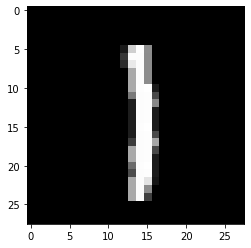

In [118]:
plt.imshow(x[1].squeeze(), cmap="gray")

In [121]:
inp = x[1].view(-1, x[0].size(1)*x[0].size(2)).cuda()

In [122]:
inp.shape

torch.Size([1, 784])

In [123]:
out = model(inp)

In [124]:
out = out.cpu()

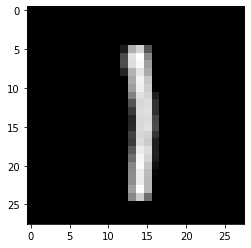

In [125]:
plt.imshow(out.detach().squeeze().view(28, 28), cmap="gray")

In [ ]:
!tensorboard --logdir=lightning_logs

TensorBoard 1.13.1 at http://macab:6006 (Press CTRL+C to quit)
I0624 06:57:36.461004 140664121583360 _internal.py:113] ::ffff:127.0.0.1 - - [24/Jun/2020 06:57:36] "GET / HTTP/1.1" 200 -
I0624 06:57:37.276897 140664121583360 _internal.py:113] ::ffff:127.0.0.1 - - [24/Jun/2020 06:57:37] "GET /tf-interactive-inference-dashboard/editedexample.png HTTP/1.1" 200 -
I0624 06:57:37.277415 140664113190656 _internal.py:113] ::ffff:127.0.0.1 - - [24/Jun/2020 06:57:37] "GET /tf-interactive-inference-dashboard/distance.png HTTP/1.1" 200 -
I0624 06:57:37.278150 140664104797952 _internal.py:113] ::ffff:127.0.0.1 - - [24/Jun/2020 06:57:37] "GET /tf-interactive-inference-dashboard/explorecounterfactuals.png HTTP/1.1" 200 -
I0624 06:57:37.285941 140664104797952 _internal.py:113] ::ffff:127.0.0.1 - - [24/Jun/2020 06:57:37] "GET /tf-interactive-inference-dashboard/pdplots.png HTTP/1.1" 200 -
I0624 06:57:37.344792 140664113190656 _internal.py:113] ::ffff:127.0.0.1 - - [24/Jun/2020 06:57:37] "GET /data/envir